<a href="https://colab.research.google.com/github/Trickshotblaster/nn-practices/blob/main/GoodShakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests

url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
text = requests.get(url)

In [2]:
import random

In [3]:
text = text.text

In [4]:
text = text.lower()
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

for ele in punc:
  if ele in text:
    text = text.replace(ele, "")

In [5]:
vocab = text.split()

In [6]:
vocab_dict = set()
for word in vocab:
  if random.randint(1, 100) > 85:
    vocab_dict.update([word])

In [7]:
len(vocab_dict)

4768

In [8]:
vocab_dict = sorted(vocab_dict)

In [9]:
stoi = {"[PAD]": 0, "[UNK]": 1}
itos = {0: "[PAD]", 1: "[UNK]"}
stoi.update({char:i+2 for i, char in enumerate(vocab_dict)})
itos.update({i+2:char for i, char in enumerate(vocab_dict)})

In [10]:
stoi['a']

3

In [11]:
itos[stoi['a']]

'a'

In [12]:
class Tokenizer:
  def __init__(self, stoi, itos, len=10):
    self.stoi = stoi
    self.itos = itos
    self.len = len
  def encode(self, text, crop=True, pad=True):
    out = []
    if crop:
      for word in text.lower().split()[:self.len]:
        if word in self.stoi:
          out.append(self.stoi[word])
        else:
          out.append(1)
      if pad:
        out = [0] * (self.len - len(out)) + out
      return out
    else:
      for word in text.lower().split():
        if word in self.stoi:
          out.append(self.stoi[word])
        else:
          out.append(1)
      if pad:
        out = [0] * (self.len - len(out)) + out
      return out
  def decode(self, ids):
    out = ""
    for id in ids:
      if (id in self.itos) and id != 1:
        out += self.itos[id] + " "
      elif id==0:
        out += '[PAD]'
      else:
        out += '[UNK] '
    return out

In [13]:
tokenizer = Tokenizer(stoi, itos)

In [14]:
tokenizer.encode("hello world", pad=False)

[1, 4697]

In [15]:
tokenizer.decode(tokenizer.encode("hello world", pad=False))

'[UNK] world '

In [16]:
import torch

In [17]:
import torch.nn.functional as F

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
num_epochs = 100000
lr = 10
batch_size = 256

In [20]:
context_len = 3
emb_dim = 20
vocab_size = len(stoi)
n_hidden = 400
C = torch.randn(vocab_size, emb_dim).to(device)
w1 = torch.randn(context_len * emb_dim, n_hidden).to(device) * 0.1
b1 = torch.randn(n_hidden).to(device) * 0.01
w2 = torch.randn(n_hidden, vocab_size).to(device) * 0.1
b2 = torch.randn(vocab_size).to(device) * 0.01

params = [C, w1, b1, w2, b2]
for p in params:
  p.requires_grad = True

tokenizer = Tokenizer(stoi, itos, len=context_len)

In [21]:
def build_dataset(text):
  xs = []
  ys = []
  tokenized_text = tokenizer.encode(text, crop=False)
  context = [0] * (context_len)
  for x in tokenized_text:
    xs.append(context)
    ys.append(x)
    context = context[1:] + [x]
  xs = torch.tensor(xs).to(device)
  ys = torch.tensor(ys).to(device)
  return xs, ys
Xtr, Ytr = build_dataset(text)
train_examples = len(Xtr) - 1

In [22]:
epochs = torch.arange(num_epochs)
losses = []

In [86]:
for epoch in range(num_epochs):
  batch_indices = torch.randint(0, train_examples, (batch_size, ))
  xs = Xtr[batch_indices]
  ys = Ytr[batch_indices]
  emb = C[xs].view(-1, emb_dim * context_len)
  l1 = (emb @ w1 + b1).tanh()
  logits = (l1 @ w2 + b2).tanh()
  loss = F.cross_entropy(logits, ys)

  losses.append(loss.item())

  for p in params:
    p.grad = None

  loss.backward()

  for p in params:
    p.data -= p.grad * (lr * ((epoch+1) ** -0.5))

  if epoch % 10000 == 0:
    print("Epoch", str(epoch) + ", loss:", loss.item())


  print(tokenizer.decode(xs[0].cpu().numpy()))
  print(tokenizer.decode([ys[0].cpu().item()]))
  selected = [logits.softmax(dim=1)[0].argmax().item()]
  print("Predicted index:", selected)
  print("Predicted word:", tokenizer.decode(selected))
  print(logits.softmax(dim=1)[0].argmax(), logits.shape)
  break

Epoch 0, loss: 7.175992488861084
nurse ah [UNK] 
thats 
Predicted index: [1]
Predicted word: [UNK] 
tensor(1, device='cuda:0') torch.Size([256, 4770])


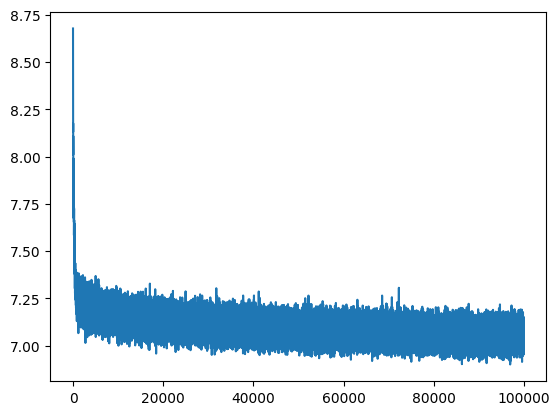

In [24]:
import matplotlib.pyplot as plt

plt.plot(epochs.numpy(), losses)

In [25]:
Xtr[100]

tensor([2076, 4129, 4709], device='cuda:0')

In [26]:
Ytr[100]

tensor(4745, device='cuda:0')

In [27]:
tokenizer.decode([Ytr[100].cpu().numpy().item()])

'yield '

In [28]:
tokenizer.decode(Xtr[100].cpu().numpy())

'if they would '

In [87]:
def prompt(text, len=10):
  with torch.no_grad():
    output = text + " "
    for x in range(len):
      xs = torch.tensor(tokenizer.encode(output)).to(device)
      emb = C[xs].view(-1, emb_dim * context_len)
      l1 = (emb @ w1 + b1).tanh()
      logits = (l1 @ w2 + b2).tanh()
      outs = logits.softmax(dim=1)[0]
      selected = torch.multinomial(outs, num_samples=1).cpu().numpy()
      outchar = tokenizer.decode(selected)
      output += outchar
    return output

In [88]:
prompt("")

' condemn trick bolingbroke arraign juliet come churchdoor stillvexd sufferance threefold '

In [30]:
def get_likelihood(input, expected):
  with torch.no_grad():
    emb = C[input].view(-1, emb_dim * context_len)
    l1 = (emb @ w1 + b1).tanh()
    logits = (l1 @ w2 + b2).tanh()
    outs = logits.softmax(dim=1)
    print(outs.shape)
    print("Max:", outs[0].argmax(), outs[0][outs.argmax()])
    return outs[0][expected]

In [31]:
get_likelihood(Xtr[100], Ytr[100])

torch.Size([1, 4770])
Max: tensor(1, device='cuda:0') tensor(0.0012, device='cuda:0', grad_fn=<SelectBackward0>)


tensor(0.0012, device='cuda:0', grad_fn=<SelectBackward0>)

In [32]:
prompt("romeo")

'romeo approbation disguised need nuptial much rogues plot lowly tedious letting '

In [33]:
prompt(tokenizer.decode(Xtr[100].cpu().numpy()))

'if they would  moody pray frame shalt departure sovereigns such come kindreds mowbray '

In [35]:
prompt("which", len=100)

'which sat gloucester thee dried wast gracious faithful rejoicing sew nurse door these scarlet signor beget heart earldom worthy oerpast taen bodies smoothing dangerous complaints taunts bay vouchsafe longlane hills treasons unconstant adjudged grievous brief pray antonio adam bound galld careful party observation armed loss successor up herald reverend far stand stool wont whatever any cried hung leash good draw drew royal thankd doings main hourly sheer longer duck devised crush true mine must adjudged a shoes worthy dost swifter tenth king puissant compelld prey doctors shamed truedisposing toil singularity insolence together aery obdurate manual lets burden temperately jogging expectst suppressd '

In [39]:
def random_prompt(text, len=10):
  with torch.no_grad():
    output = text + " "
    for x in range(len):
      xs = torch.tensor(tokenizer.encode(output)).to(device)
      emb = C[xs].view(-1, emb_dim * context_len)
      l1 = (emb @ w1 + b1).tanh()
      logits = (l1 @ w2 + b2).tanh()
      logits = torch.ones(logits.shape)
      outs = logits.softmax(dim=1)
      selected = torch.multinomial(outs, num_samples=1)[0].cpu().numpy()
      outchar = tokenizer.decode(selected)
      output += outchar
    return output

In [40]:
random_prompt("", len=100)

' meek noise necessary whats people wherewith villains france trail needless souls volumes lead moral bolt passable shore wills policy peaceful coast takest hours devices smile hardly angry rebellion swore clamour worlds heirs fortunes consenting land aloof becomest friendships blind dale mothers bloods goose sweetly remorse sure tutor stage agatestone panting burthens revenged minnows white also understand distressed vessel follows straind singularity elements teeming cannibals fester prattling mistaking earls judgmentday mouths banishment floods violets guilt weep cheerly arts longer worth alls golden begins bloody crying not army vassal mount incessant side spur bawdy hangs slept refelld grant rarer kinsmen ungovernd than '

random is better